### Preprocessing

In [1]:
import pickle

with open('embedding_labels.pkl', 'rb') as lf:
    labels = pickle.load(lf)

with open('embedding_posts.pkl', 'rb') as pf:
    posts = pickle.load(pf)

In [2]:
# Tokenizing data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 50
test_samples = 5000
training_samples = 30000
validation_samples = 10000
max_words = 10000

Using TensorFlow backend.


In [3]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(posts)
sequences = tokenizer.texts_to_sequences(posts)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 116582 unique tokens


In [4]:
data = pad_sequences(sequences, maxlen=maxlen)

In [5]:
labels = np.asarray(labels)

In [6]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (396704, 50)
Shape of label tensor: (396704,)


In [7]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [8]:
label_dictionary = {
    'I': 0,
    'E': 1
}

labels = [label_dictionary[label[:1]] for label in labels]

In [22]:
x_test = data[:test_samples]
y_test = labels[:test_samples]
x_train = data[test_samples:test_samples+training_samples]
y_train = labels[test_samples:test_samples+training_samples]
x_val = data[test_samples + training_samples:
             test_samples + training_samples + validation_samples]
y_val = labels[test_samples + training_samples:
               test_samples + training_samples + validation_samples]

In [10]:
print (len(x_test))
print (len(x_train))
print (len(x_val))

5000
30000
10000


In [11]:
import os

embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [18]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 580,065
Trainable params: 580,065
Non-trainable params: 0
_________________________________________________________________
Train on 30000 samples, validate on 10000 samples
Epoch 1/10
30000/30000 [==============================] - 8s 281us/step - loss: 0.5452 - acc: 0.7676 - val_loss: 0.5499 - val_acc: 0.7641
Epoch 2/10
30000/30000 [==============================] - 7s 246us/step - loss: 

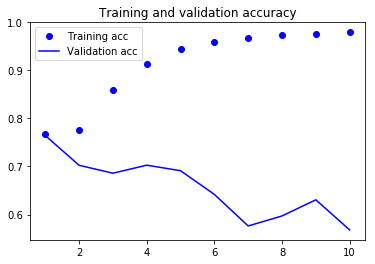

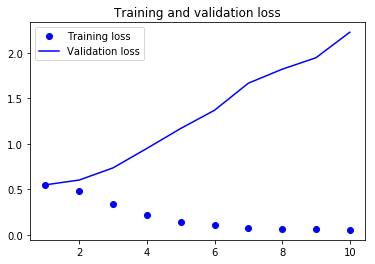

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

5000/5000 [==============================] - 0s 38us/step


[0.8824865707397461, 0.682]